# 0. ETF Selection

We select the SPDR Gold Shares (GLD) ETF as the gold ETF. It is traded on Nasdaq, the currency is USD.

Similarly, we choose the Amundi CAC 40 UCITS ETF-C (C40.PA) as the equity ETF. It will track the CAC 40 index of France. It is traded on Paris Euronext, the currency is EUR.

Data source: https://finance.yahoo.com/

# 1. Data Importing

In [1]:
import arch
import holidays
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from scipy import stats
from matplotlib import pyplot as plt

In [2]:
gold_df = pd.read_csv("data/SPDR_Gold_Shares_USD.csv")
equity_df = pd.read_csv("data/C40.PA.csv")

Convert the data into the datetime format and make it the index to query the dataframe easier.

In [3]:
gold_df["Date"] = pd.to_datetime(gold_df["Date"], format="%Y-%m-%d")
gold_df.set_index("Date", inplace=True)
equity_df["Date"] = pd.to_datetime(equity_df["Date"], format="%Y-%m-%d")
equity_df.set_index("Date", inplace=True)

Verify that the time range is correct.

In [4]:
gold_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-10-01,138.070007,140.190002,137.800003,139.630005,139.630005,12476200
2019-10-02,140.789993,141.880005,140.460007,141.259995,141.259995,11914300
2019-10-03,141.360001,143.250000,141.289993,141.899994,141.899994,12396100
2019-10-04,141.479996,142.309998,141.139999,141.899994,141.899994,9651000
2019-10-07,141.160004,141.770004,140.240005,140.690002,140.690002,6127200


In [5]:
gold_df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-11-22,138.369995,138.460007,137.660004,137.740005,137.740005,3620300
2019-11-25,137.320007,137.619995,136.990005,137.080002,137.080002,6415800
2019-11-26,136.979996,137.800003,136.580002,137.740005,137.740005,4724400
2019-11-27,137.029999,137.210007,136.830002,137.009995,137.009995,4111000
2019-11-29,137.100006,138.130005,137.080002,137.860001,137.860001,4516400


In [6]:
equity_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-10-01,83.650002,83.650002,81.970001,81.989998,81.989998,0
2019-10-02,82.019997,82.019997,79.459999,79.500000,79.500000,0
2019-10-03,79.500000,79.500000,79.500000,79.500000,79.500000,0
2019-10-04,79.989998,80.699997,79.830002,80.699997,80.699997,0
2019-10-07,80.599998,81.320000,80.379997,81.320000,81.320000,0


In [7]:
equity_df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-11-25,87.099998,87.180000,86.930000,87.129997,87.129997,0
2019-11-26,87.180000,87.349998,87.180000,87.279999,87.279999,0
2019-11-27,87.209999,87.500000,87.120003,87.169998,87.169998,0
2019-11-28,86.930000,87.059998,86.910004,86.970001,86.970001,0
2019-11-29,86.709999,87.199997,86.650002,86.669998,86.669998,0


One notable difference between gold and equity prices is that we have prices for gold ETF every day of a week while we don't have prices for equity ETF for weekends (Saturday and Sunday). In order to make the analysis comparable, we will drop the prices of gold ETF on Saturday and Sunday before making further preprocessing and analysis.

Another difference is that November 28, 2019 is a Bank Holiday in the US market and we don't have the data that day for the gold ETF. In order to calculate the Pearson correlation, we will also drop the data of that day for the equity market to have two time series with the same length.

In [8]:
gold_df = gold_df[gold_df.index.dayofweek < 5]
gold_df.shape

(43, 6)

In [9]:
equity_df = equity_df[equity_df.index != "2019-11-28"]
equity_df.shape

(43, 6)

# 2. Data Processing

We use adjusted close prices to calculate the daily returns. Adjusted close prices are the prices that already take into account stock split and dividends, which reflex more accurate the change of the prices.

In [10]:
gold_df["Daily Return"] = gold_df["Adj Close"].pct_change(1)
gold_df.head()

,Open,High,Low,Close,Adj Close,Volume,Daily Return
Date,,,,,,,
2019-10-01,138.070007,140.190002,137.800003,139.630005,139.630005,12476200,NaN
2019-10-02,140.789993,141.880005,140.460007,141.259995,141.259995,11914300,0.011674
2019-10-03,141.360001,143.250000,141.289993,141.899994,141.899994,12396100,0.004531
2019-10-04,141.479996,142.309998,141.139999,141.899994,141.899994,9651000,0.000000
2019-10-07,141.160004,141.770004,140.240005,140.690002,140.690002,6127200,-0.008527


In [11]:
equity_df["Daily Return"] = equity_df["Adj Close"].pct_change(1)
equity_df.head()

,Open,High,Low,Close,Adj Close,Volume,Daily Return
Date,,,,,,,
2019-10-01,83.650002,83.650002,81.970001,81.989998,81.989998,0,NaN
2019-10-02,82.019997,82.019997,79.459999,79.500000,79.500000,0,-0.030370
2019-10-03,79.500000,79.500000,79.500000,79.500000,79.500000,0,0.000000
2019-10-04,79.989998,80.699997,79.830002,80.699997,80.699997,0,0.015094
2019-10-07,80.599998,81.320000,80.379997,81.320000,81.320000,0,0.007683


# 3. Data Summaries

The value at 2019-10-31 is the statistic for the whole October, likewise, the value at 2019-11-30 is the statistic for November.

The daily high minus low and the required statistics of part 7 will also be presented here.

In [12]:
gold_df["High minus low"] = gold_df["High"] - gold_df["Low"]
equity_df["High minus low"] = equity_df["High"] - equity_df["Low"]

In [13]:
gold_df.resample('M').mean()

,Open,High,Low,Close,Adj Close,Volume,Daily Return,High minus low
Date,,,,,,,,
2019-10-31,140.847391,141.384349,140.303043,140.874782,140.874782,7.757257e+06,0.000921,1.081305
2019-11-30,138.611500,139.056000,138.083502,138.570500,138.570500,6.961465e+06,-0.001611,0.972498


In [14]:
equity_df.resample('M').mean()

,Open,High,Low,Close,Adj Close,Volume,Daily Return,High minus low
Date,,,,,,,,
2019-10-31,82.614347,82.982173,82.206957,82.605217,82.605217,2.0,0.001231,0.775217
2019-11-30,86.508500,86.817500,86.339501,86.609000,86.609000,5.1,0.001485,0.477999


In [15]:
gold_df.resample('M').std()

,Open,High,Low,Close,Adj Close,Volume,Daily Return,High minus low
Date,,,,,,,,
2019-10-31,0.972620,0.929309,0.950674,0.831229,0.831229,2.804327e+06,0.006173,0.479405
2019-11-30,1.618235,1.588269,1.585444,1.562095,1.562095,2.994154e+06,0.006188,0.492552


In [16]:
equity_df.resample('M').std()

,Open,High,Low,Close,Adj Close,Volume,Daily Return,High minus low
Date,,,,,,,,
2019-10-31,1.501841,1.432122,1.584090,1.552722,1.552722,9.591663,0.010074,0.533521
2019-11-30,0.756392,0.679898,0.697564,0.629928,0.629928,22.341606,0.004221,0.182428


# 4. Graphing

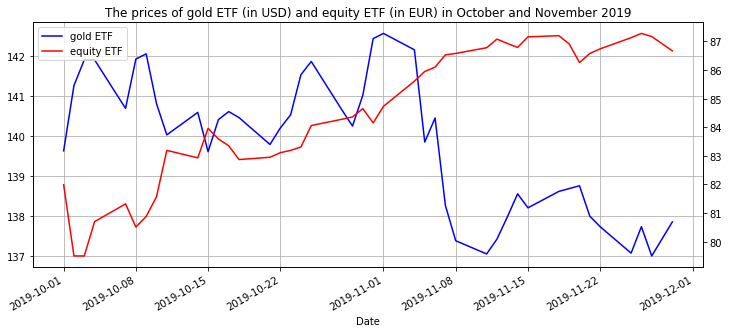

In [17]:
plt.figure(figsize=(12,5))
plt.title('The prices of gold ETF (in USD) and equity ETF (in EUR) in October and November 2019')

ax1 = gold_df["Adj Close"].plot(color='blue', grid=True, label='gold ETF')
ax2 = equity_df["Adj Close"].plot(color='red', grid=True, secondary_y=True, label='equity ETF')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h1+h2, l1+l2, loc=2)
plt.show()

# 6. Modelling Prices

In [18]:
def get_data(df, month, column):
    return df[(df.index >= f"2019-{month:02d}-01") & (df.index < f"2019-{(month+1):02d}-01")][column]

ARMA model is a specific case of ARIMA model with i = 0, that allows us to use the ARIMA model here.

In [19]:
def fit_arima(data):
    model = ARIMA(data, order=(3,0,3))
    model_fit = model.fit()
    print(model_fit.summary())

In [20]:
df_name = {0: "gold ETF", 1: "equity ETF"}
month_name = {10: "October", 11: "November"}
for index, df in enumerate([gold_df, equity_df]):
    for month in [10, 11]:
        print("-" * 78)
        print("-" * 78)
        print("-" * 78)
        print(f"ARMA model for {df_name[index]} in {month_name[month]}")
        data = get_data(df, month, "Adj Close")
        fit_arima(data)

------------------------------------------------------------------------------
------------------------------------------------------------------------------
------------------------------------------------------------------------------
ARMA model for gold ETF in October


C:\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  warnings.warn('No frequency information was'
C:\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  warnings.warn('No frequency information was'
C:\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  warnings.warn('No frequency information was'
C:\Python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zero

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                   23
Model:                 ARIMA(3, 0, 3)   Log Likelihood                 -21.992
Date:                Tue, 12 Jan 2021   AIC                             59.985
Time:                        10:17:17   BIC                             69.069
Sample:                    10-01-2019   HQIC                            62.269
                         - 10-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        140.8067      0.109   1290.215      0.000     140.593     141.021
ar.L1          0.0995      0.407      0.245      0.807      -0.698       0.897
ar.L2          0.4517      0.387      1.168      0.2

C:\Python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  warnings.warn('No frequency information was'
C:\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  warnings.warn('No frequency information was'
C:\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  warnings.warn('No frequency information was'


                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                   20
Model:                 ARIMA(3, 0, 3)   Log Likelihood                 -22.205
Date:                Tue, 12 Jan 2021   AIC                             60.409
Time:                        10:17:17   BIC                             68.375
Sample:                             0   HQIC                            61.964
                                 - 20                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        138.8141      0.872    159.140      0.000     137.104     140.524
ar.L1          0.7245      0.352      2.056      0.040       0.034       1.415
ar.L2          0.8184      0.471      1.736      0.0

C:\Python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has be

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                   23
Model:                 ARIMA(3, 0, 3)   Log Likelihood                 -24.804
Date:                Tue, 12 Jan 2021   AIC                             65.608
Time:                        10:17:18   BIC                             74.692
Sample:                    10-01-2019   HQIC                            67.893
                         - 10-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         82.7812      0.758    109.242      0.000      81.296      84.266
ar.L1          0.8193      0.370      2.217      0.027       0.095       1.544
ar.L2          0.7588      0.429      1.769      0.0

C:\Python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# 7. Modelling Volatility

The high minus low for the ETF's prices and their average, as well as the standard deviation of returns are presented in part 3

In [30]:
def fit_garch(data):
    garch = arch.arch_model(data, vol='garch', p=1, o=0, q=1)
    garch_fitted = garch.fit()
    print(garch_fitted.summary())

In [32]:
for index, df in enumerate([gold_df, equity_df]):
    for month in [10, 11]:
        print("-" * 78)
        print("-" * 78)
        print("-" * 78)
        print(f"GARCH model for {df_name[index]} in {month_name[month]}")
        data = get_data(df, month, "Daily Return")
        data = data.dropna()
        fit_garch(data)

------------------------------------------------------------------------------
------------------------------------------------------------------------------
------------------------------------------------------------------------------
GARCH model for gold ETF in October
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2211987.449503363
Iteration:      2,   Func. Count:     16,   Neg. LLF: -81.257589920448
Optimization terminated successfully    (Exit mode 0)
            Current function value: -81.25758995275967
            Iterations: 6
            Function evaluations: 16
            Gradient evaluations: 2
                     Constant Mean - GARCH Model Results                      
Dep. Variable:           Daily Return   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:                81.2576
Distribution:                  Normal   AIC:                

C:\Users\trinh\AppData\Roaming\Python\Python38\site-packages\arch\univariate\base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.638e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\trinh\AppData\Roaming\Python\Python38\site-packages\arch\univariate\base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.638e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\trinh\AppData\Roaming\Python\Py

In [23]:
data = gold_df[gold_df.index >= "2019-11-01"]["Daily Return"]
fit_garch(data)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 12684817.542295108
Iteration:      2,   Func. Count:     16,   Neg. LLF: -73.97790009442136
Optimization terminated successfully    (Exit mode 0)
            Current function value: -73.9779001217992
            Iterations: 6
            Function evaluations: 16
            Gradient evaluations: 2
                     Constant Mean - GARCH Model Results                      
Dep. Variable:           Daily Return   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:                73.9779
Distribution:                  Normal   AIC:                          -139.956
Method:            Maximum Likelihood   BIC:                          -135.973
                                        No. Observations:                   20
Date:                Tue, Jan 12 2021   Df Residuals:                       16
Time:          

C:\Users\trinh\AppData\Roaming\Python\Python38\site-packages\arch\univariate\base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.638e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


# 8. Correlation

In [24]:
stats.pearsonr(gold_df[gold_df.index >= "2019-11-01"]["Daily Return"], equity_df[equity_df.index >= "2019-11-01"]["Daily Return"])

(-0.4119305823448921, 0.07112222594040687)

In [25]:
stats.pearsonr(gold_df[("2019-10-01" < gold_df.index) & (gold_df.index < "2019-11-01")]["Daily Return"], equity_df[("2019-10-01" < equity_df.index) & (equity_df.index < "2019-11-01")]["Daily Return"])

(-0.6625802932767255, 0.0007794017160281523)